> Created on Sat Sep 30 14:59:20 2023 @author: Richie Bao-caDesign设计(cadesign.cn)

# 3.9-C 强化学习——多智能体强化学习（MARL）

## 3.9.1 从一个智能体到多个智能体

现实中的很多问题都存在合作/协作（cooperative）、竞争（competitive）的关系，例如在各类体育运动项目，竞技游戏中的拳击项目为两个选手间的竞争关系；足球项目为两个队之间的竞争关系，但在各个队内部为协作关系；而救援队的救援任务只有成员间的协作关系等。单个智能体无法实现协作和竞争关系模拟，需要建立可以之间交互的多个（甚至百千，或更多）智能体来实现（同时存在与环境间的交互），即为多智能体强化学习（multi-agents reinforcement learning，MARL）。

以伊辛（Ising）模型为例解释 MARL。

### 3.9.1.1 伊辛模型 

#### 1）伊辛模型

伊辛模型（Ising（Lenz-Ising）model），以物理学家  Ernst Ising  和 Wilhelm Lenz 命名，是统计力学（statistical mechanics）中铁磁性（Ferromagnetism）的数学模型，由处于两种状态（+1 或 -1），代表原子“自旋（spins）”磁偶极矩（ magnetic dipole moments）（描述磁性强度和方向的物理量）的离散变量组成。原子的自旋被表示在一个晶格（lattice）中，每个自旋与相邻的自旋相互作用，且相邻的自旋与该自旋相一致情况的能量低于不一致的情况，但热扰乱了这种趋势，从而产生了不同结构相（structural phases）的可能性<sup>[Ising model-Wikipedia, <https://en.wikipedia.org/wiki/Ising_model>]</sup>。同时可以查看*计算机视觉中的马尔可夫网*部分对伊辛模型的描述。

物理学家试图研究电子如何“排列”自己，及温度如何影响这一过程（加热磁铁超过一定温度会导致其突然失去磁力）。单个电子会产生磁场，而微小的电子会影响其附近的其它电子，使电子之间朝向一个方向排列或者相反的方向。当排列的电子数量增加，磁场增大并在材料上产生一些内部应变，电子会形成簇，称为（电）畴（domains），是指自发极化方向相同的小区域，电畴与电畴之间的边界称为畴壁。例如部分电子排列为自旋向上的畴，而部分排列为相邻自旋向下的畴，在非常局部的水平上，电子通过排列来最小化它们的能量。为了对这一现象建模，避免材料中数万亿电子之间的相互作用而仅假设电子只受其最近邻域电子的影响，这与上述邻域$Q$学习的假设完全相同。

考虑一个晶格（位置）点集合$\Lambda$，每个晶格点都有一组相邻的点形成一个$d$-维晶格。对于每一个晶格点$k\in\Lambda$，存在一个离散变量$\sigma_k$，使得$\sigma_k\in\{-1, +1\}$，表示该晶格点的自旋。一个自旋构型（spin configuration），${\sigma} = \{\sigma_k\}_{k\in\Lambda}$是为每个晶格点赋予一个自旋值。对于任意两个临近的点，$i, j\in\Lambda$，存在一个相互作用$J_{ij}$。并且，点$j\in\Lambda$有一个与其交互的外部磁场（external magnetic field）$h_j$。自旋构型${\sigma}$的能量由哈密尔顿函数（Hamiltonian function）给出，$H(\sigma) = -\sum_{\langle ij\rangle} J_{ij} \sigma_i \sigma_j - \mu \sum_j h_j \sigma_j$，式中，第一个和为相邻自旋对的和（每对计算一次）。符号$\langle ij\rangle$表示点$i$和$j$为最近邻。$\mu$为磁矩（magnetic moment）。注意，因为电子的磁矩与自旋是反平行的，哈密尔顿函数第二项的符号应该为正，用符号为一种惯例。构型概率（configuration probability）由玻尔兹曼分布（Boltzmann distribution）给出，为参数温度的倒数$\beta\geq0$：$P_\beta(\sigma) = \frac{e^{-\beta H(\sigma)}}{Z_\beta}$，式中，$\beta = (k_{\rm B} T)^{-1}$，归一化常数为$Z_\beta = \sum_\sigma e^{-\beta H(\sigma)}$，为配分函数（partition function）（在物理学中，配分函数描述了处于热力学平衡状态系统的统计性质）。物理学中的玻尔兹曼分布即为 SoftMax 函数，可以查看*SoftMax回归（函数、归一化指数函数）*部分内容。自旋的函数可以表述为$\langle f \rangle_\beta = \sum_\sigma f(\sigma) P_\beta(\sigma)$，是$f$的期望值（均值）。构型概率$P_{\beta}(\sigma)$表示系统（在平衡状态下）在构型$\sigma$状态下的概率。

依据哈密尔顿函数$H(\sigma)$，伊辛模型可以根据相互作用的符号分类，对于点对$i,j$，

$J_{ij} > 0$，相互作用称为铁磁的（ferromagnetic）；

$J_{ij} < 0$，相互作用称为反铁磁的（antiferromagnetic）；

$J_{ij} = 0$，表示自旋间并无相互作用。

在铁磁的伊辛模型中，自旋倾向于一致，即相邻自旋的构型为相同符号的概率更大；在反铁磁的伊辛模型中，相邻自旋倾向于相反的符号。

$H(\sigma)$也解释了点$j$自旋与外部磁场的相互作用，

$h_j > 0$，点$j$的自旋倾向于向正方向排列；

$h_j < 0$，点$j$的自旋倾向于向反方向排列；

$h_j = 0$，没有外部的影响。

伊辛模型通常在没有外部磁场与晶格作用情况下检验，因此$H(\sigma)$可以简化为$H(\sigma) = -\sum_{\langle i~j\rangle} J_{ij} \sigma_i \sigma_j$；另外，假设所有的最近邻${\langle ij\rangle}$具有相同的相互作用强度，因此可以设$J_{ij}=J$，$H(\sigma)$进一步简化为$H(\sigma) = -J \sum_{\langle i~j\rangle} \sigma_i \sigma_j$。

#### 2）蒙特卡罗方法 

蒙特卡罗（Monte Carlo，MC）方法为依赖于重复的随机抽样来获得数值结果的一类广泛计算方法。其基本的概念是使用随机性（randomness）来解决原则上可能是确定性（deterministic）的问题，通常可用于解决任何具有概率解释的问题。根据大数定律，由某个随机变量期望值描述的积分可以通过取该变量独立样本的经验均值（empirical mean）（样本均值（sample mean））来近似<sup>[Metropolis, Nicholas; Rosenbluth, Arianna W.; Rosenbluth, Marshall N.; Teller, Augusta H.; Teller, Edward (1 June 1953). "Equation of State Calculations by Fast Computing Machines". The Journal of Chemical Physics. 21 (6): 1087–1092. Bibcode:1953JChPh..21.1087M. doi:10.1063/1.1699114. ISSN 0021-9606. OSTI 4390578. S2CID 1046577.][ Hastings, W. K. (1 April 1970). "Monte Carlo sampling methods using Markov chains and their applications". Biometrika. 57 (1): 97–109. Bibcode:1970Bimka..57...97H. doi:10.1093/biomet/57.1.97. ISSN 0006-3444. S2CID 21204149.][Liu, Jun S.; Liang, Faming; Wong, Wing Hung (1 March 2000). "The Multiple-Try Method and Local Optimization in Metropolis Sampling". Journal of the American Statistical Association. 95 (449): 121–134. doi:10.1080/01621459.2000.10473908. ISSN 0162-1459. S2CID 123468109.]</sup>。当变量的概率分布被参数化时，经常使用马尔可夫蒙特卡罗（ Markov chain Monte Carlo，MCMC）采样器，其核心思想是设计一个具有给定平稳概率分布的马尔可夫链模型，即在极限情况下，由 MCMC 方法生成的样本将是来自期望(目标)分布的样本<sup>[Spall, J. C. (2003). "Estimation via Markov Chain Monte Carlo". IEEE Control Systems Magazine. 23 (2): 34–45. doi:10.1109/MCS.2003.1188770.][Hill, Stacy D.; Spall, James C. (2019). "Stationarity and Convergence of the Metropolis-Hastings Algorithm: Insights into Theoretical Aspects". IEEE Control Systems Magazine. 39: 56–67. doi:10.1109/MCS.2018.2876959. S2CID 58672766.]</sup>。通过遍历定理（ergodic theorem），用 MCMC 采样器随机状态的经验测度来近似平稳分布。

另外，从满足非线性演化方程的概率分布序列中生成图形（例如伊辛模型），这些概率分布流（flows）总可被解释为马尔可夫过程的随机状态分布，其转移概率（transition probabilities）取决于当前随机状态的分布，这些模型可以看作非线性马尔可夫链随机状态规律的演化。为避免概率分布流越来越高的采样复杂度，模拟这些复杂非线性马尔可夫过程的一种自然方法是对该过程的多个副本进行采样，用采样的经验测度（empirical measures）代替演化方程中随机状态的未知分布。当迭代次数足够大时（系统趋于无穷大时），这些随机经验测度将收敛于非线性马尔可夫链随机态的确定性分布，使得样本（粒子（particles）、个体（individuals）、智能体（agents）等）间的统计相互作用消失<sup>[Monte Carlo method-Wikipedia, <https://en.wikipedia.org/wiki/Monte_Carlo_method>]</sup>。

MC 方法各有不同，但往往遵循一个特定模式：

1. 定义一个可能输入的域（domain）；
2. 从域上的概率分布随机生成输入；
3. 对输入执行确定性操作；
4. 汇总结果。

下述代码<sup>[Value of Pi using Monte Carlo – PYTHON PROGRAM, <https://www.bragitoff.com/2021/05/value-of-pi-using-monte-carlo-python-program/>]</sup>为应用 MC 方法近似计算圆周率（$\pi$），过程如下：

1. 假设正方形横纵坐标区间均为`[-1,+1]`，则其面积为$2 \times 2=4$；
2. 从均匀分布（uniform distribution）中生成足够多的样本点坐标，并落于正方形内；
3. 计算落于半径为1，原点为`(0,0)`圆内样本点的数量；
4. 落于圆内样本点数量与总共样本数量的比值为圆形和正方形区域面积比的估计值；
5. 已知正方形面积为4，及圆和正方形的比值，因此可以求出圆形面积，进而得到$\pi$值。

In [3]:
%load_ext autoreload 
%autoreload 2 
import usda.rl as usda_rl   

import numpy as np
import torch
from matplotlib import pyplot as plt

from IPython.display import HTML
from tqdm import tqdm

In [3]:
def pi_using_MonteCarlo(nTrials=int(10E7)): 
    # Input parameters
    radius = 1
    #-------------
    # Counter for the points inside the circle
    nInside = 0
     
    # Generate points in a square of side 2 units, from -1 to 1.
    XrandCoords = np.random.default_rng().uniform(-1, 1, (nTrials,))
    YrandCoords = np.random.default_rng().uniform(-1, 1, (nTrials,))
     
    for i in range(nTrials):
        x = XrandCoords[i]
        y = YrandCoords[i]
        # Check if the points are inside the circle or not
        if x**2+y**2<=radius**2:
            nInside = nInside + 1
    
    area = 4*nInside/nTrials
    print("Value of Pi: ",area)
    
pi_using_MonteCarlo()

Value of Pi:  3.14150196


定义`pi_using_MonteCarlo_anim()`函数，实现 MC 方法计算$\pi$，随采样数量增加，采样点分布和$\pi$估计值的变化。

In [7]:
anim=usda_rl.pi_using_MonteCarlo_anim(nTrials=int(5e4))  
anim.save('../imgs/3_9_c/pi_mc.gif')
HTML(anim.to_jshtml())

<img src="../imgs/3_9_c/pi_mc_small.gif" height='auto' width='auto' title="caDesign"> 

#### 3）2 维度伊辛模型的 MC 模拟

在统计学和统计物理中，Metropolis–Hastings 算法是一种从难以直接抽样的概率分布中获得随机样本序列的 MCMC 方法。该序列可用于近似分布（例如生成直方图）或计算积分（例如期望值）。Metropolis–Hastings 算法和其它 MCMC 算法通常用于从多维分布中采样，特别是高维数情况<sup>[Metropolis–Hastings algorithm-Wikepedia, <https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm>]</sup>。Nicholas Metropolis 等人<sup>Metropolis, Nicholas; Rosenbluth, Arianna W.; Rosenbluth, Marshall N.; Teller, Augusta H.; Teller, Edward (1 June 1953). "Equation of State Calculations by Fast Computing Machines". The Journal of Chemical Physics. 21 (6): 1087–1092. Bibcode:1953JChPh..21.1087M.</sup>于 1953 年提出了该算法，称为 Metropolis 算法。到 1970 年，W.K. Hastings<sup>[Hastings, W.K. (1970). "Monte Carlo Sampling Methods Using Markov Chains and Their Applications". Biometrika. 57 (1): 97–109. Bibcode:1970Bimka..57...97H. doi:10.1093/biomet/57.1.97. JSTOR 2334940. Zbl 0219.65008.]</sup> 将其扩展到更一般的方法，即 Metropolis–Hastings 算法。Nicholas Metropolis 等人在其论文中描述把$N$个粒子置于任意的构型（configuration）中，例如规则的晶格。然后按照$X \rightarrow X+\alpha \xi_1;Y \rightarrow Y+\alpha \xi_2$ 方式移动每个粒子，式中，$\alpha $为最大允许位移（此处为任意值）；$\xi_1$和$\xi_2$为`[-1,1]`区间的随机数。在移动一个粒子之后，它同样有可能在以其原始位置为中心，边为$2\alpha$的正方形内的任何地方。然后计算由粒子移动引起的系统能量变化$\Delta E$，如果$\Delta E<0$，即粒子移动使得系统达到较低能量的状态，因此允许粒子移动并置于新的位置；如果$\Delta E>0$，则将以概率$\exp (-\Delta E / k T)$移动，即取一个`[0,1]`区间的随机数$\xi$，如果$\xi<\exp (-\Delta E / k T)$，将粒子移动到其新的位置。如果$\xi>\exp (-\Delta E / k T)$，则返回到原来的位置。且无论粒子是否发生了位移，系统均处于一个新的构型中。

根据 Metropolis 算法，书写 2 维度伊辛模型的 MC 模拟代码<sup>[Simulating the Ising model, <https://github.com/rajeshrinet/compPhy/tree/master/ising/>]</sup>，其中对应 Metropolis 算法 的代码如下：

```python
def mcmove(self, config, beta):
    ''' This is to execute the monte carlo moves using Metropolis algorithm such that detailed balance condition is satisified'''
    N=self.N
    for i in range(N):
        for j in range(N):            
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]         
                nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                cost = 2*s*nb
                if cost < 0:	
                    s *= -1
                elif rand() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    return config
```

下面的试验中比较了不同温度参数`temp`为0.4和10的结果，当温度较低时，电子的自旋倾向于朝向一个方向，保持磁性；而当温度较高时，电子的自旋倾向于朝向相反的方向，从而失去磁性。

100%|███████████████████████████████████████████████| 500/500 [32:12<00:00,  3.87s/it]


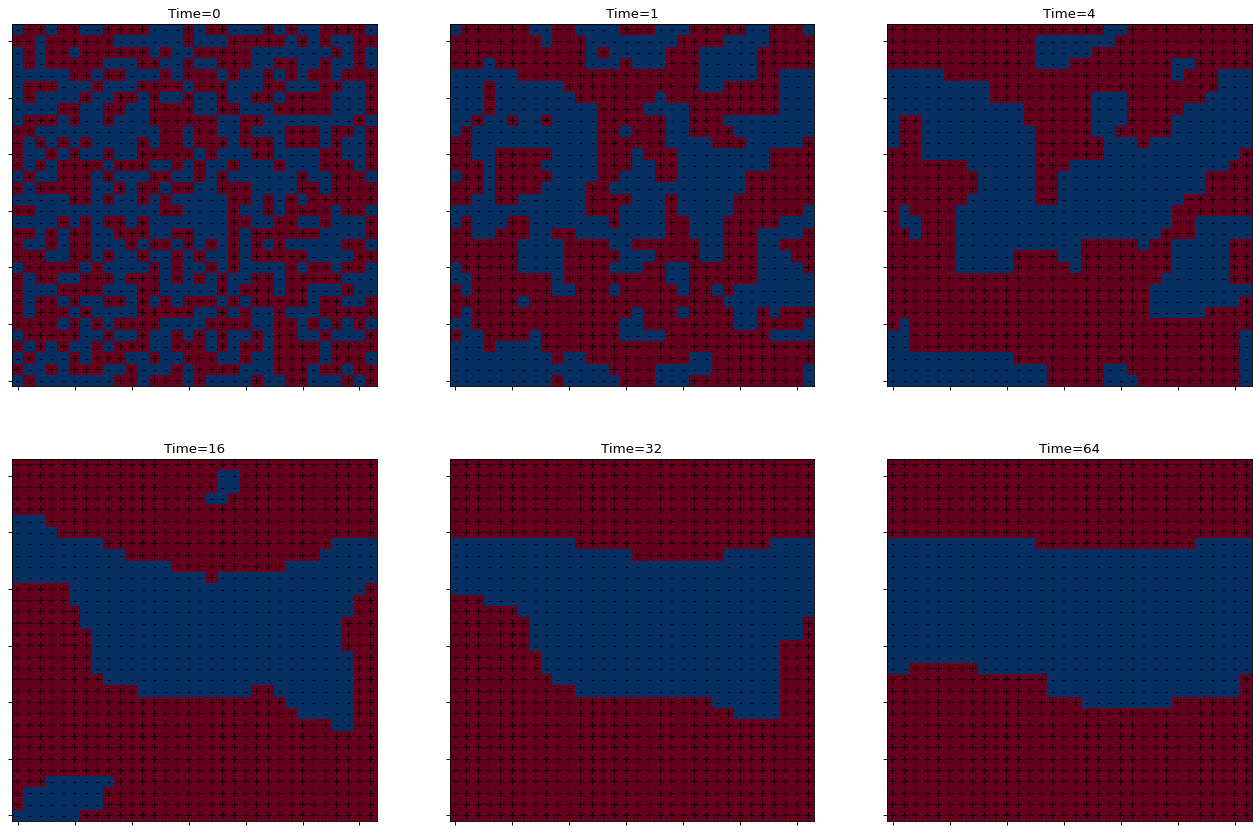

In [8]:
ising=usda_rl.Ising_Metropolis_MCMC(N=32,temp=.4)
ising.simulate(1001,idxes=[1,4,16,32,64],figsize=(20,20))

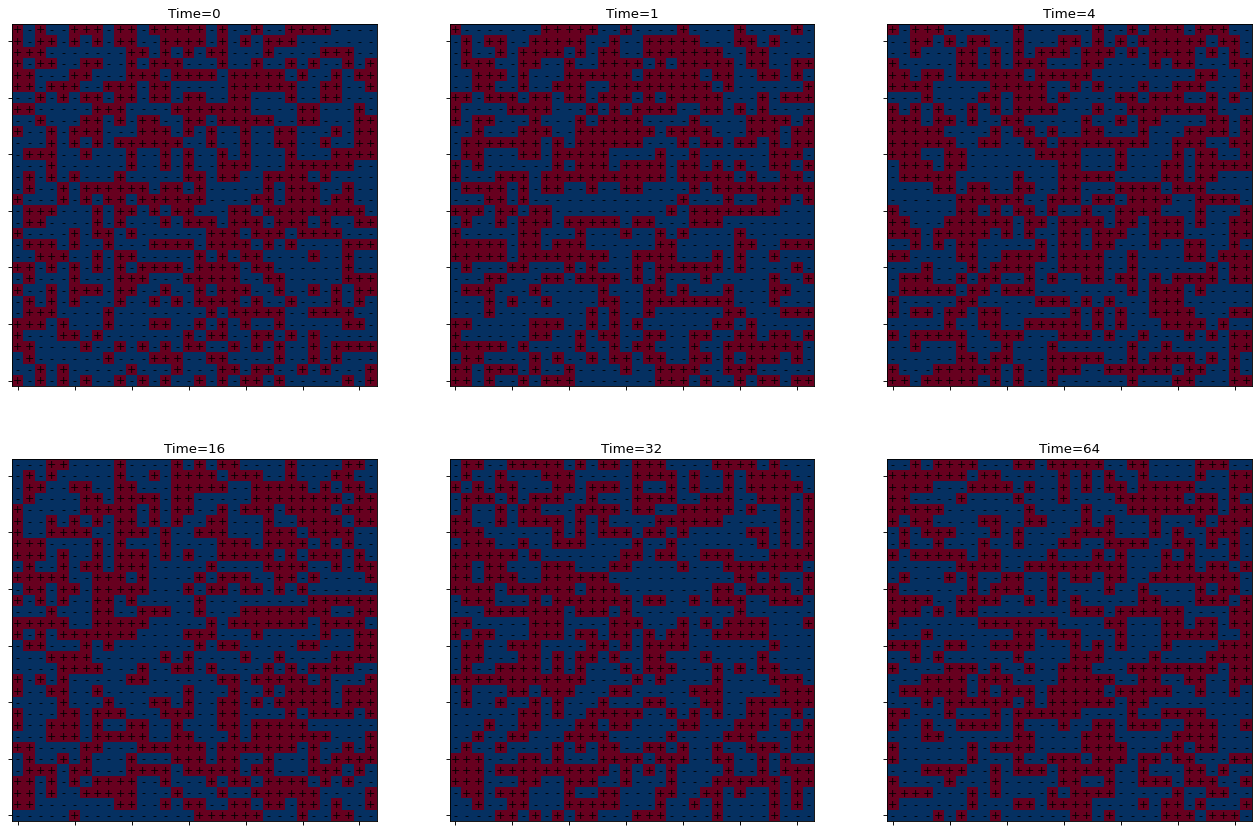

In [9]:
ising=usda_rl.Ising_Metropolis_MCMC(N=32,temp=10)
ising.simulate(1001,idxes=[1,4,16,32,64],figsize=(20,20))

### 3.9.1.2 伊辛模型的 MARL 模拟<sup>[Zai, A., & Brown, B. (2020). Deep reinforcement learning in action. Manning Publications.]</sup>

#### 1） 多智能体的维度问题

一个常规的 $Q$（动作价值）函数表述为$Q(s, a): S \times A \rightarrow R$，为“状态-动作”二元组对应收益的函数。当扩展到多个智能体，每个智能体都会与其它智能体交互，则智能体$j$的$Q$函数可以表述为$ Q_j\left(s, a_j, a_{-j}\right): S \times A_j \times A_{-j} \rightarrow R$，式中，$-j$为除索引为$j$的智能体外的所有其它智能体。该类型的多智能体$Q$函数，能够保证训练收敛，从而学习到最优价值和策略函数。但是当智能体的数量很大时，则联合动作空间（ joint action-space）$a_{-j}$随着智能体的数量呈指数增长${\mid A \mid}^N$，例如如果一个智能体有上下左右等4个动作，那么如果有两个智能体时则动作的组合方式有$4^2=16$个，为三个时就有64个，按$4^N$的方式增长。用独热编码向量（one-hot vector）表示一个智能体的4个动作时，可表示为`[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]`等，那么对于4个动作的两个智能体的联合动作空间，则可一般表示为，

<img src="../imgs/3_9_c/3_9_c_01.jpg" height='auto' width=200 title="caDesign"> 

为了解决联合动作空间随智能体增加而指数级增长的问题，根据大多数环境下彼此邻近的智能体才会产生重大影响的现象，则不需要模拟环境中所有智能体的联合动作，而仅考虑每一智能体与其邻域内智能体的联合动作。即将整个联合动作空间划分为一组重叠的子空间，并只计算这些小得多的子空间$Q$值，称为邻域$Q$学习（neighborhood Q-learning）或子空间$Q$学习（subspace Q-learning ）。例如，对于有4个动作的100个智能体，其完整的联合动作空间大小为$4^{100}$，这是个难以处理的数量级。而如果配置邻域大小为3，则邻域联合动作空间大小为$4^3=64$，为一个可以计算的数量级。为这100个智能体的每一个均构建这样的一个邻域联合动作空间向量，并用于计算每个智能体的$Q$值。

#### 2） 1 维度伊辛模型的 MARL 模拟——邻域$Q$学习

定义`Ising_MARL`类，实现1维度和2维度伊辛模型的 MARL 模拟。首先创建一个二进制的数字晶格，用数字 1 表示电子自旋向上（spin-up），数字 0 表示电子自旋向下（spin-down），即一个智能体存在2个动作。因为只考虑每个电子与其邻域两个电子之间的相互作用，因此联合动作空间大小为$2^2=4$。在1维度的伊辛模型试验中，配置晶格大小为20，即为状态空间大小，随机初始化电子的自旋方向，如下。

tensor([1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1],
       dtype=torch.uint8)


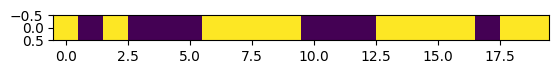

In [36]:
size=(20,)
hid_layer=20 
epochs=200
lr=0.001 

ising_1d=usda_rl.Ising_MARL(size,hid_layer,epochs,lr)
print(ising_1d.grid)
plt.imshow(np.expand_dims(ising_1d.grid,0));

“状态-动作”二元组对应收益的函数定义为每个电子与其领域两个电子之间的自旋朝向关系，如果朝向均一致则具有最大的收益；如果朝向均不同，则获得最小的收益。如下代码，

```python
def get_reward_1d(self,s,a): 
    r = -1
    for i in s:
        if i == a:
            r += 0.9
    r *= 2.
    return r  
```

`get_reward_1d`函数中参数`s`为邻域电子的自旋方向（状态）列表，在1维度伊辛模型中为对应到每个电子左右相邻的各一个电子。如果该电子位于最左或最右的晶格，则其左和右的邻域电子对应到最右和最左的晶格，即晶格是一个连续的闭环。参数$a$为当前电子的状态。初始的收益`r=-1`，如果所有电子朝向一致（自旋向上后向下）有最大收益为1.6；如果邻域电子与当前电子朝向均不同，则有最小收益为-2.0；如果邻域有一个电子与当前电子朝向同，则获得收益约为-0.2。

根据邻域电子状态返回联合状态（动作），例如一个电子邻域两个电子的状态为`[0,1]`时（表示其中一个自旋向上，一个向下），其联合状态为`[0,1,0,0]`；如果为`[0,0]`，则为`[1,0,0,0]`；如果为`[1,0]`，则为`[0,0,1,0]`；如果为`[1,1]`，则为`[0,0,0,1]`。对应上述联合状态结果的计算代码如下，

```python
def get_substate(self,b): 
    s = torch.zeros(2) 
    if b > 0: 
        s[1] = 1
    else:
        s[0] = 1
    return s

def joint_state(self,s): 
    s1_ = self.get_substate(s[0]) 
    s2_ = self.get_substate(s[1])
    ret = (s1_.reshape(2,1) @ s2_.reshape(1,2)).flatten() 
    return ret        
```

根据两个邻域电子联合状态空间（大小为4），由定义$Q$(价值)函数的神经网络模型返回当前电子动作（动作空间大小为2）的价值估计值（即动作的联合概率），选择概率最大的动作作为当前电子要执行的动作。定义$Q$(价值)函数的神经网络模型如下，

```python
def qfunc(self,s,theta,layers=[(4,20),(20,2)],afn=torch.tanh):
    l1n = layers[0] 
    l1s = np.prod(l1n) 
    theta_1 = theta[0:l1s].reshape(l1n) 
    l2n = layers[1]
    l2s = np.prod(l2n)
    theta_2 = theta[l1s:l2s+l1s].reshape(l2n)
    bias = torch.ones((1,theta_1.shape[1]))
    l1 = s @ theta_1 + bias 
    l1 = torch.nn.functional.elu(l1)
    l2 = afn(l1 @ theta_2) 
    return l2.flatten() 
```

> 代码的作者 Zai, A.<sup>[Zai, A., & Brown, B. (2020). Deep reinforcement learning in action. Manning Publications.]</sup> 使用`Numpy`结合`PyTorch`库完成神经网络的构建，这对理解完全用`PyTorch`构建的神经网络是有帮助的。

根据$Q$函数返回的价值估计值选择当前电子执行的动作，执行该动作后当前电子的状态的表述与所执行的动作一致，为自旋向上或向下。比较当前电子的状态和邻域两个电子的状态，由动作收益函数`get_reward_1d`返回收益值。用该收益值更新$Q$价值函数的对应动作的估计值（$Q$值），并用欧几里德距离度量计算更新前后$Q$值间的距离作为损失，从而完成前向传播计算。由`PyTorch`库完成反向传播梯度计算，并指定学习率`lr`更新`Q`函数神经网络的参数值。训练`Q`函数神经网络的代码如下，

```python
def train_1d(self):
    self.losses = [[] for i in range(self.size[0])] 
      
    for i in range(self.epochs):
        for j in range(self.size[0]): 
            l = j - 1 if j - 1 >= 0 else self.size[0]-1 
            r = j + 1 if j + 1 < self.size[0] else 0 
            state_ = self.grid[[l,r]] 
            state = self.joint_state(state_) 
            qvals = self.qfunc(state.float().detach(),self.params[j],layers=[(4,self.hid_layer),(self.hid_layer,2)])
            qmax = torch.argmax(qvals,dim=0).detach().item() 
            action = int(qmax)
            self.grid_[j] = action 
            reward = self.get_reward_1d(state_.detach(),action)
            with torch.no_grad(): 
                target = qvals.clone()
                target[action] = reward
            loss = torch.sum(torch.pow(qvals - target,2))
            self.losses[j].append(loss.detach().numpy())
            loss.backward()
            with torch.no_grad(): 
                self.params[j] = self.params[j] - self.lr * self.params[j].grad
            self.params[j].requires_grad = True
    
        with torch.no_grad(): 
            self.grid.data =self.grid_.data  
```

完成$Q$价值函数神经网络的训练后，打印每次迭代的损失`self.losses`，和最终更新后的晶格构型`grid`（状态估计值）如下。

tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.uint8) tensor(10)


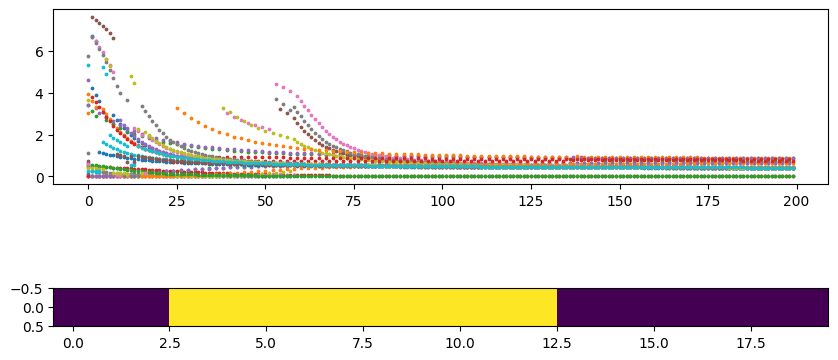

In [37]:
ising_1d.train_1d()
usda_rl.ising_1d_plot(ising_1d.losses,ising_1d.grid,size)

#### 3） 2维度伊辛模型的 MARL 模拟——MF-Q <sup>[Yaodong Yang, Rui Luo, Minne Li, Ming Zhou, Weinan Zhang, & Jun Wang. (2020). Mean Field Multi-Agent Reinforcement Learning.]</sup>

在1维度伊辛模型中，如果不采取领域$Q$学习的方式，而是计算当前电子（智能体）之外所有电子的联合动作（状态），那么其大小将为$2^{20}$。虽然领域$Q$学习大幅度减小了联合状动作空间的大小，但是如果增加维度，例如对于2维度的伊辛模型，其邻域电子个数为8，则其联合动作空间将为$2^8=256$；继续增加维度到3维空间，领域电子数将为26，联合动作空间大小则为$2^{26}$，这使得计算又变得困难。

邻域方法在伊辛模型中起作用的原因是因为电子的自旋受其最近邻域磁场的影响最大。如果将邻域各电子的联合动作空间，考虑到各单个电子自旋的影响转化为邻域所有电子自旋和，这将避免联合动作空间大小的影响。例如在1维度的伊辛模型中，邻域两个电子的动作分别为`[1,0]`和`[0,1]`（独热编码向量），那么其和为`[1,1]`。进一步将和除以所有邻域电子数，归一化结果为`[0.5,0.5]`，则是邻域电子动作的概率分布。同上述过程，Yaodong Yang等人<sup>[Yaodong Yang, Rui Luo, Minne Li, Ming Zhou, Weinan Zhang, & Jun Wang. (2020). Mean Field Multi-Agent Reinforcement Learning.]</sup>提出了平均场（Mean Field） MARL，对应到`Q`学习算法为平均场$Q$学习（mean field Q-learning ，MF-Q），公式表述为$Q^j(s, \boldsymbol{a})=\frac{1}{N^j} \sum_{k \in \mathcal{N}(j)} Q^j\left(s, a^j, a^k\right)$，式中，$\mathcal{N}(j)$是索引值为$j$的智能体其邻域智能体索引集，大小$N^j=|\mathcal{N}(j)|$。 

在2维伊辛模型模拟试验中，由 SoftMax 归一化指数函数策略，根据 $q$价值函数的估计值计算动作分布概率，从而选择概率最大的动作，定义`softmax_policy`方法代码如下，

```python
def softmax_policy(self,qvals,temp=0.9): 
    soft = torch.exp(qvals/temp) / torch.sum(torch.exp(qvals/temp))     
    action = torch.multinomial(soft,1) 
    return action  
```

输入参数`temp`为温度参数。当温度趋近于无限大时， SoftMax 返回的联合动作概率分布趋向于均匀分布，概率差异最小化，最终导致电子自旋方向倾向于互相取反，磁性消失；当温度趋近于无限小时，概率差异最大化，导致电子自旋倾向于向上或向下，与邻域电子大多数的自旋方向相一致，从而保持磁性。

动作收益函数在2维中变为当前电子采取动作后的状态与邻域电子平均场向量之间的差异，例如如果当前电子执行动作后的状态为`[0,1]`，假设邻域电子状态平均场向量为`[0,1]`，则距离计算结果的距离为 0.986；如果平均场向量为`[0.25,0.75]`，那么计算结果的距离为0.848，具体实现的函数`get_reward_2d`代码如下，

```python
def get_reward_2d(action,action_mean): 
        r = (action*(action_mean-action/2)).sum()/action.sum() 
        return torch.tanh(5 * r) 
```

首先随机初始化2维伊辛模型的晶格构型，状态大小为$10 \times 10$，如下结果。

tensor([[1, 0, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 1, 0, 1, 0, 0, 0, 0, 1, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 1, 0, 0]], dtype=torch.uint8)
tensor(48)


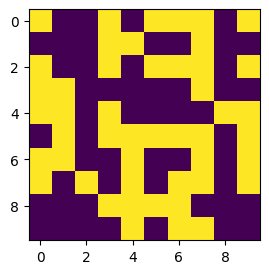

In [8]:
size=(10,10)
hid_layer = 10 
epochs = 200
lr = 0.0001     
num_iter = 3

ising_2d=usda_rl.Ising_MARL(size,hid_layer,epochs,lr)    
print(ising_2d.grid)

fig,ax = plt.subplots(figsize=(3,3))
ax.imshow(ising_2d.grid)
print(ising_2d.grid.sum())

配置温度参数为`temp=0.4`，温度较低，电子的自旋倾向于朝向一个方向，保持磁性。

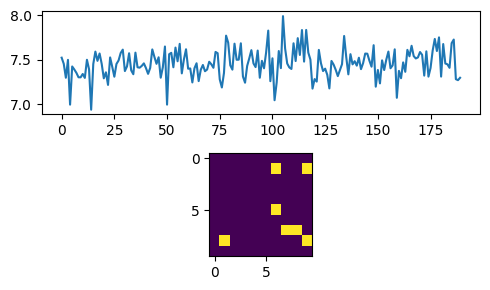

In [11]:
ising_2d.train_2d(num_iter,temp=0.4)
usda_rl.ising_2d_plot(ising_2d.losses,ising_2d.grid)

配置温度参数为`temp=10`，温度较高，电子的自旋倾向于朝向相反的方向，从而失去磁性。

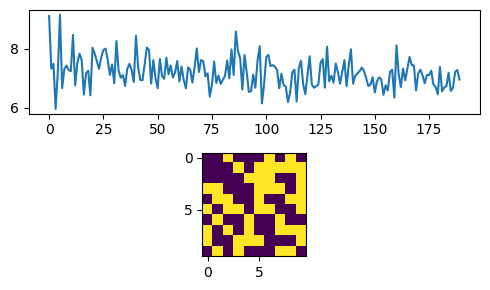

In [12]:
ising_2d.train_2d(num_iter,temp=10)
usda_rl.ising_2d_plot(ising_2d.losses,ising_2d.grid)

## 3.9.2 MARL 环境集成和算法集成

### 3.9.2.1 环境和算法集成

#### 1）环境集成

在多个智能体的 RL 环境中，环境集成的库较为多样，如下表格罗列了主要或具有代表性的一些库环境。

| 序号  | 库名称  | 说明  | 图示  |
|---|---|---|---|
| 1  | [PettingZoo](https://pettingzoo.farama.org/)  | 为解决一般 MARL 问题，Python 化的简单环境集成库。包括有多种环境，实用程序工具，可以自定义环境。其中[AEC API](https://pettingzoo.farama.org/api/aec/)支持基于顺序回合的环境（sequential turn based environments），[Parallel API](https://pettingzoo.farama.org/api/parallel/)支持并行多线程计算。|Atari：基于 [Arcade（街机）学习环境](https://github.com/Farama-Foundation/Arcade-Learning-Environment)，其在现代 RL 发展中起到重要作用。</br> <img src="../imgs/3_9_c/pettingzoo_atari.gif" height='auto' width='auto' title="caDesign"></br>Butterfly：为[Farama](https://farama.org)创造的具有挑战性的场景。所有环境都需要高度的协调，需要学习突发行为来实现最优策略。因此，目前学习这些环境非常具有挑战性。</br> <img src="../imgs/3_9_c/pettingzoo_Butterfly.gif" height='auto' width='auto' title="caDesign"> </br> Classic：经典流行的回合制游戏，大多数具有竞争性。</br> <img src="../imgs/3_9_c/pettingzoo_Classic_min.gif" height='auto' width='auto' title="caDesign"></br>MPE（Multi Particle Environments）：多粒子环境，是一组面向通信环境（communication oriented environment），其中粒子智能体可以移动、通信、看到彼此、推断彼此，并于固定地标交互的环境。这些环境来源于[OpenAI’s MPE](https://github.com/openai/multiagent-particle-envs)</br><img src="../imgs/3_9_c/pettingzoo_MPE.gif" height='auto' width='auto' title="caDesign"></br>SISL：由斯坦福智能系统实验室（Stanford Intelligent Systems Laboratory，SISL）创建，包括3个协作式多智能体基准环境。</br><img src="../imgs/3_9_c/pettingzoo_a_SISL_min.gif" height='auto' width='auto' title="caDesign">  |
| 2  | [Jumanj](https://github.com/instadeepai/jumanji)  | 用[JAX（Autograd and XLA）](https://github.com/google/jax) 编写的可扩展的 RL 环境。Jumanji 正在帮助引领 RL 领域硬件加速的研究和开发，其高速环境支持更快的迭代和大规模实验，同时降低了复杂性。 | <img src="../imgs/3_9_c/Jumanj-min.gif" height='auto' width='auto' title="caDesign">   |
| 3  | [robotic-warehouse（RWARE）](https://github.com/semitable/robotic-warehouse)  |  多机器人仓库根据现实世界的应用模拟了一个由机器人移动和交付所需货物的仓库。 | <img src="../imgs/3_9_c/rware_min.gif" height='auto' width='auto' title="caDesign">  |
| 4  | [VMAS（Vectorized Multi-Agent Simulator）](https://github.com/proroklab/VectorizedMultiAgentSimulator)  | 为矢量化多智能体模拟器，是一个为有效的 MARL 基准测试而编写设计的矢量化框架，由 PyTorch 编写的矢量化 2D 物理引擎和一组具有挑战性的多机器人环境组成。VMAS 模拟不同形状的智能体和地标，并支持旋转、弹性碰撞、关节（joints）和自定义重力。为了简化模拟，使用了完整的运动模型，并可以自定义诸如雷达等传感器，且支持智能体之间的通信，可以按批次执行模拟，无缝扩展到千万级别的并行环境中。 VMAS 具有与[OpenAI Gym](https://github.com/openai/gym)、[RLlib](https://docs.ray.io/en/latest/rllib/index.html)和 [torchrl](https://github.com/pytorch/rl)等相兼容的接口，可以与更广泛的 RL 算法集成，其灵感来自于[OpenAI's MPE](https://github.com/openai/multiagent-particle-envs)。|  <img src="../imgs/3_9_c/VMAS_scenarios_min.gif" height='auto' width='auto' title="caDesign"> |
| 5  | [MAgent2](https://github.com/Farama-Foundation/MAgent2)  | 格网世界（gridworld）中大量像素智能体在战斗或者其它竞争性场景中相互作用交互。  | <img src="../imgs/3_9_c/adversarial_pursuit_min.gif" height='auto' width='auto' title="caDesign">   |
| 6  | [AI-Economist](https://github.com/salesforce/ai-economist) |  为一个用于模拟含有智能体和政府的社会经济行为和动态，弹性、模块化和可组合的环境框架。| <img src="../imgs/3_9_c/ai_economic.jpg" height='auto' width='auto' title="caDesign"> <sup>[Stephan Zheng, Alexander Trott, Sunil Srinivasa, David C. Parkes, & Richard Socher. (2021). The AI Economist: Optimal Economic Policy Design via Two-level Deep Reinforcement Learning.]</sup>  |
| 7 | [Nocturne](https://github.com/facebookresearch/nocturne)  | 为一个 2D，部分观察（partially observed）的驾驶模拟器。使用 C++ 构建以提供计算速度，并导出为 Python 库。Nocturne 设计的目的是处理来自[Waymo Open Dataset（Waymo 开源数据集）](https://github.com/waymo-research/waymo-open-dataset) 的交通场景，并可以拓展到其它驾驶数据集。Nocturne可以训练自动驾驶汽车的控制器来解决 Waymo 数据集中的各种任务，并将其作为基准来评估设计的控制器。 |   <img src="../imgs/3_9_c/Nocturne_min.gif" height='auto' width='auto' title="caDesign">  |
| 8  | [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents)  |  [Unity](https://unity.com)机器学习智能体工具包（Unity Machine Learning Agents Toolkit，ML-Agents）是将游戏和模拟作为环境用于智能体训练的开源项目。ML-Agents 提供有基于 PyTorch 库实现的先进算法，使游戏开发人员和爱好者能够轻松训练2D、3D和 VR/AR 游戏的智能体。研究人员还可以使用其提供的简单易用的 Python API，用RL、模拟学习（imitation learning）、神经进化（neuroevolution），或者任何其它方法训练智能体。这些经过训练的智能体可用于游戏开发的过程，也可以用于任何相关的领域场景。 |  <img src="../imgs/3_9_c/Complex-AI-environments_0.jpg" height='auto' width='auto' title="caDesign"> |
| 9  | [Neural MMO](https://github.com/openai/neural-mmo)  |  Neural MMO 由 OpenAI 发布，用于 MARL 大型多智能体游戏环境。该平台在一个持久且开放的任务中支持大量、可变数量的智能体。许多智能体和物种的纳入可以带来更好的探索、形成不同生态位（divergent niche formation）和更高的综合能力。  |  <img src="../imgs/3_9_c/Neural_MMO_min.gif" height='auto' width='auto' title="caDesign">  |

#### 2）算法集成

下述列出的 RL 算法含有适合单个智能体同时适合多个智能体，及仅适合单个或多个智能体的算法，算法收集于[CleanRL](https://github.com/vwxyzjn/cleanrl)、[Tianshou (天授) ](https://github.com/thu-ml/tianshou)、[RLlib](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html)和[Stable-Baselines3（SB3）](https://stable-baselines3.readthedocs.io/en/master/)等几个 RL 算法集成库。

| 序号  | 算法  | 论文  | 备注  |
|---|---|---|---|
| 1  | A2C，Advantage Actor-Critic（优势动作评价）  | Asynchronous Methods for Deep Reinforcement Learning<sup>[Volodymyr Mnih, Adrià Puigdomènech Badia, Mehdi Mirza, Alex Graves, Timothy P. Lillicrap, Tim Harley, David Silver, and Koray Kavukcuoglu. Asynchronous methods for deep reinforcement learning. In Proceedings of the 33nd International Conference on Machine Learning, ICML 2016, New York City, NY, USA, June 19-24, 2016, 1928–1937. 2016. URL: http://proceedings.mlr.press/v48/mniha16.html.]</sup>  |   |
| 2  | A3C，Asynchronous Advantage Actor-Critic  | Asynchronous Methods for Deep Reinforcement Learning<sup>[Volodymyr Mnih, Adrià Puigdomènech Badia, Mehdi Mirza, Alex Graves, Timothy P. Lillicrap, Tim Harley, David Silver, and Koray Kavukcuoglu. Asynchronous methods for deep reinforcement learning. In Proceedings of the 33nd International Conference on Machine Learning, ICML 2016, New York City, NY, USA, June 19-24, 2016, 1928–1937. 2016. URL: http://proceedings.mlr.press/v48/mniha16.html.]</sup>  |   |
| 3  | AlphaZero，Single-Player Alpha Zero  | Mastering Chess and Shogi by Self-Play with a General Reinforcement Learning Algorithm<sup>[David Silver, Thomas Hubert, Julian Schrittwieser, Ioannis Antonoglou, Matthew Lai, Arthur Guez, Marc Lanctot, Laurent Sifre, Dharshan Kumaran, Thore Graepel, Timothy Lillicrap, Karen Simonyan, & Demis Hassabis. (2017). Mastering Chess and Shogi by Self-Play with a General Reinforcement Learning Algorithm.]</sup>  |   |
| 4  | APPO，Asynchronous Proximal Policy Optimization  |Proximal Policy Optimization Algorithms<sup>[John Schulman, Filip Wolski, Prafulla Dhariwal, Alec Radford, and Oleg Klimov. Proximal policy optimization algorithms. CoRR, 2017. URL: http://arxiv.org/abs/1707.06347, arXiv:1707.06347.]</sup>    |   |
| 5  |ARS，Augmented Random Search   | Simple random search provides a competitive approach to reinforcement learning<sup>[Horia Mania, Aurelia Guy, & Benjamin Recht. (2018). Simple random search provides a competitive approach to reinforcement learning.]</sup>   |   |
| 6  | BanditLinUCB，Linear Upper Confidence Bound   | Linear Upper Confidence Bound Algorithm for Contextual Bandit Problem with Piled Rewards<sup>[Huang, H.T. (2016). Linear Upper Confidence Bound Algorithm for Contextual Bandit Problem with Piled Rewards. In Advances in Knowledge Discovery and Data Mining (pp. 143–155). Springer International Publishing.]</sup>   |   |
| 7  | BC，Behavior Cloning  |  Exponentially Weighted Imitation Learning for Batched Historical Data<sup>[Wang, Q., Xiong, J., Han, L., sun, p., Liu, H., & Zhang, T. (2018). Exponentially Weighted Imitation Learning for Batched Historical Data. In Advances in Neural Information Processing Systems. Curran Associates, Inc..]</sup>  |   |
| 8  | CQL，Conservative Q-Learning  | Conservative Q-Learning for Offline Reinforcement Learning<sup>[Aviral Kumar, Aurick Zhou, George Tucker, & Sergey Levine. (2020). Conservative Q-Learning for Offline Reinforcement Learning.]</sup>   |   |
| 9  | CRR，Critic Regularized Regression  |  Critic Regularized Regression<sup>[Ziyu Wang, Alexander Novikov, Konrad Zolna, Jost Tobias Springenberg, Scott Reed, Bobak Shahriari, Noah Siegel, Josh Merel, Caglar Gulcehre, Nicolas Heess, & Nando de Freitas. (2021). Critic Regularized Regression.]</sup>  |   |
| 10  | C51，Categorical DQN  |  A Distributional Perspective on Reinforcement Learning<sup>[Marc G. Bellemare, Will Dabney, & Rémi Munos. (2017). A Distributional Perspective on Reinforcement Learning.]</sup> |   |
|  11 | DDPG，Deep Deterministic Policy Gradient（深度确定性策略梯度）  | Continuous control with deep reinforcement learning<sup>[Timothy P. Lillicrap, Jonathan J. Hunt, Alexander Pritzel, Nicolas Heess, Tom Erez, Yuval Tassa, David Silver, and Daan Wierstra. Continuous control with deep reinforcement learning. In 4th International Conference on Learning Representations, ICLR 2016, San Juan, Puerto Rico, May 2-4, 2016, Conference Track Proceedings. 2016. URL: http://arxiv.org/abs/1509.02971.]</sup>  |   |
|12   | APEX_DDPG（Ape-X），Distributed Prioritized Experience Replay  | Distributed Prioritized Experience Replay<sup>[Dan Horgan, John Quan, David Budden, Gabriel Barth-Maron, Matteo Hessel, Hado van Hasselt, & David Silver. (2018). Distributed Prioritized Experience Replay.]</sup>   |   |
| 13  | DreamerV3  | Mastering Diverse Domains through World Models<sup>[Danĳar Hafner, Jurgis Pasukonis, Jimmy Ba, & Timothy Lillicrap. (2023). Mastering Diverse Domains through World Models.]</sup>   |   |
| 14  | Dreamer  |  Dream to Control: Learning Behaviors by Latent Imagination<sup>[Danĳar Hafner, Timothy Lillicrap, Jimmy Ba, & Mohammad Norouzi. (2020). Dream to Control: Learning Behaviors by Latent Imagination.]</sup>  |   |
| 15  | DQN，Deep Q Network（深度Q网络）  |  Human-level control through deep reinforcement learning<sup>[Volodymyr Mnih, Koray Kavukcuoglu, David Silver, Andrei A. Rusu, Joel Veness, Marc G. Bellemare, Alex Graves, Martin A. Riedmiller, Andreas Fidjeland, Georg Ostrovski, Stig Petersen, Charles Beattie, Amir Sadik, Ioannis Antonoglou, Helen King, Dharshan Kumaran, Daan Wierstra, Shane Legg, and Demis Hassabis. Human-level control through deep reinforcement learning. Nature, 518(7540):529–533, 2015. URL: https://doi.org/10.1038/nature14236, doi:10.1038/nature14236.]</sup>  |   |
| 16  | APEX_DQN（Ape-X），Distributed Prioritized Experience Replay   | Distributed Prioritized Experience Replay<sup>[Dan Horgan, John Quan, David Budden, Gabriel Barth-Maron, Matteo Hessel, Hado van Hasselt, & David Silver. (2018). Distributed Prioritized Experience Replay.]</sup>  |   |
| 17  | DDQN，Double DQN（双网络深度Q学习）  | Deep reinforcement learning with double q-learning<sup>[Hado van Hasselt, Arthur Guez, and David Silver. Deep reinforcement learning with double q-learning. In Proceedings of the Thirtieth AAAI Conference on Artificial Intelligence, February 12-17, 2016, Phoenix, Arizona, USA, 2094–2100. 2016. URL: http://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/view/12389.]</sup>  |   |
| 18  | ES，Evolution Strategies  | Evolution Strategies as a Scalable Alternative to Reinforcement Learning<sup>[Tim Salimans, Jonathan Ho, Xi Chen, Szymon Sidor, & Ilya Sutskever. (2017). Evolution Strategies as a Scalable Alternative to Reinforcement Learning.]</sup>   |   |
| 19  | GAE，Generalized Advantage Estimator（广义优势函数估计器）  | High-dimensional continuous control using generalized advantage estimation<sup>[John Schulman, Philipp Moritz, Sergey Levine, Michael I. Jordan, and Pieter Abbeel. High-dimensional continuous control using generalized advantage estimation. In 4th International Conference on Learning Representations, ICLR 2016, San Juan, Puerto Rico, May 2-4, 2016, Conference Track Proceedings. 2016. URL: http://arxiv.org/abs/1506.02438.]</sup>  |   |
| 20  | HER，Hindsight Experience Repla  | Hindsight Experience Replay<sup>[Marcin Andrychowicz, Filip Wolski, Alex Ray, Jonas Schneider, Rachel Fong, Peter Welinder, Bob McGrew, Josh Tobin, Pieter Abbeel, & Wojciech Zaremba. (2018). Hindsight Experience Replay.]</sup>   |   |
| 21  | IMPALA，Importance Weighted Actor-Learner Architecture  | IMPALA: Scalable Distributed Deep-RL with Importance Weighted Actor-Learner Architectures<sup>[Lasse Espeholt, Hubert Soyer, Remi Munos, Karen Simonyan, Volodymir Mnih, Tom Ward, Yotam Doron, Vlad Firoiu, Tim Harley, Iain Dunning, Shane Legg, & Koray Kavukcuoglu. (2018). IMPALA: Scalable Distributed Deep-RL with Importance Weighted Actor-Learner Architectures.]</sup>   |   |
| 22  | LeelaChessZero，MultiAgent LeelaChessZero  | Lc0<sup>[Lc0, <https://github.com/LeelaChessZero/lc0/>]</sup>   |   |
| 23  |MAML，Model-Agnostic Meta-Learning    | Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks<sup>[Chelsea Finn, Pieter Abbeel, & Sergey Levine. (2017). Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks.]</sup>   |   |
| 24  | MARWIL，Monotonic Advantage Re-Weighted Imitation Learning  | Exponentially Weighted Imitation Learning for Batched Historical Data<sup>[Wang, Q., Xiong, J., Han, L., sun, p., Liu, H., & Zhang, T. (2018). Exponentially Weighted Imitation Learning for Batched Historical Data. In Advances in Neural Information Processing Systems. Curran Associates, Inc..]</sup>   |   |
|25   | MB-MPO，Model-Based Meta-Policy-Optimization  | Model-Based Reinforcement Learning via Meta-Policy Optimization<sup>[Ignasi Clavera, Jonas Rothfuss, John Schulman, Yasuhiro Fujita, Tamim Asfour, & Pieter Abbeel. (2018). Model-Based Reinforcement Learning via Meta-Policy Optimization.]</sup>   |   |
|  26 | PG，Policy Gradient（策略梯度）   |  Policy gradient methods for reinforcement learning with function approximation<sup>[Richard S. Sutton, David A. McAllester, Satinder P. Singh, and Yishay Mansour. Policy gradient methods for reinforcement learning with function approximation. In Advances in Neural Information Processing Systems 12, [NIPS Conference, Denver, Colorado, USA, November 29 - December 4, 1999], 1057–1063. 1999. URL: http://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.]</sup> |   |
| 27  | PPO，Proximal Policy Optimization（近端策略优化）  | Proximal policy optimization algorithms<sup>[John Schulman, Filip Wolski, Prafulla Dhariwal, Alec Radford, and Oleg Klimov. Proximal policy optimization algorithms. CoRR, 2017. URL: http://arxiv.org/abs/1707.06347, arXiv:1707.06347.]</sup>   |   |
| 28  |PPG，Phasic Policy Gradient   | Phasic Policy Gradient<sup>[Karl Cobbe, Jacob Hilton, Oleg Klimov, & John Schulman. (2020). Phasic Policy Gradient.]</sup>  |   |
|  29 | PER，Prioritized Experience Replay（优先级经验重放）  | Prioritized experience replay<sup>[Tom Schaul, John Quan, Ioannis Antonoglou, and David Silver. Prioritized experience replay. In 4th International Conference on Learning Representations, ICLR 2016, San Juan, Puerto Rico, May 2-4, 2016, Conference Track Proceedings. 2016. URL: http://arxiv.org/abs/1511.05952.]</sup>  |   |
|  30 |   Qdagger |  Reincarnating Reinforcement Learning: Reusing Prior Computation to Accelerate Progress<sup>[Rishabh Agarwal, Max Schwarzer, Pablo Samuel Castro, Aaron Courville, & Marc G. Bellemare. (2022). Reincarnating Reinforcement Learning: Reusing Prior Computation to Accelerate Progress.]</sup> |   |
| 31  | RND，Random Network Distillation  | Exploration by Random Network Distillation<sup>[Yuri Burda, Harrison Edwards, Amos Storkey, & Oleg Klimov. (2018). Exploration by Random Network Distillation.]</sup>  |   |
| 32  | R2D2，Recurrent Replay Distributed DQN  | Recurrent Experience Replay in Distributed Reinforcement Learning<sup>[Steven Kapturowski, Georg Ostrovski, John Quan, Remi Munos, & Will Dabney (2018). Recurrent Experience Replay in Distributed Reinforcement Learning. In International Conference on Learning Representations.]</sup>   |   |
| 33  | SAC，Soft Actor-Critic（软动作评价）  | Soft actor-critic algorithms and applications<sup>[Tuomas Haarnoja, Aurick Zhou, Kristian Hartikainen, George Tucker, Sehoon Ha, Jie Tan, Vikash Kumar, Henry Zhu, Abhishek Gupta, Pieter Abbeel, and Sergey Levine. Soft actor-critic algorithms and applications. CoRR, 2018. URL: http://arxiv.org/abs/1812.05905, arXiv:1812.05905.]</sup>  |   |
| 34  | SlateQ  |SLATEQ: A Tractable Decomposition for Reinforcement Learning with Recommendation Sets<sup>[Ie, E., Jain, V., Wang, J., Narvekar, S., Agarwal, R., Wu, R., Cheng, H.T., Chandra, T., & Boutilier, C. (2019). SLATEQ: A Tractable Decomposition for Reinforcement Learning with Recommendation Sets. In Proceedings of the 28th International Joint Conference on Artificial Intelligence (pp. 2592–2599). AAAI Press.</sup>    |   |
| 35  | TD3，Twin Delayed DDPG（双延迟深度确定性策略梯度）  | Addressing function approximation error in actor-critic methods<sup>[Scott Fujimoto, Herke van Hoof, and David Meger. Addressing function approximation error in actor-critic methods. In Proceedings of the 35th International Conference on Machine Learning, ICML 2018, Stockholmsmässan, Stockholm, Sweden, July 10-15, 2018, 1582–1591. 2018. URL: http://proceedings.mlr.press/v80/fujimoto18a.html.]</sup>  |   |
| 36  |QMIX，QMIX Monotonic Value Factorisation   | QMIX: Monotonic Value Function Factorisation for Deep Multi-Agent Reinforcement Learning<sup>[Tabish Rashid, Mikayel Samvelyan, Christian Schroeder de Witt, Gregory Farquhar, Jakob Foerster, & Shimon Whiteson. (2018). QMIX: Monotonic Value Function Factorisation for Deep Multi-Agent Reinforcement Learning.]</sup>   |   |
| 37  |MADDPG，Multi-Agent Deep Deterministic Policy Gradient   | Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments<sup>[Ryan Lowe, Yi Wu, Aviv Tamar, Jean Harb, Pieter Abbeel, & Igor Mordatch. (2020). Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments.]</sup>   |   |
|38   | Parameter Sharing  | Cooperative Multi-Agent Control Using Deep Reinforcement Learning<sup>[Gupta, M. (2017). Cooperative Multi-agent Control Using Deep Reinforcement Learning. In Autonomous Agents and Multiagent Systems (pp. 66–83). Springer International Publishing.]</sup>   |   |
| 39  |  Fully Independent Learning |  Multi-Agent and Hierarchical<sup>[Multi-Agent and Hierarchical, <https://docs.ray.io/en/latest/rllib/rllib-env.html#multi-agent-and-hierarchical>]</sup>  |   |
| 40  | Shared Critic Methods  | Implementing a Centralized Critic<sup>[Implementing a Centralized Critic, <https://docs.ray.io/en/master/rllib/rllib-env.html#implementing-a-centralized-critic>]</sup>  |   |
| 41  | Curiosity (ICM: Intrinsic Curiosity Module)  | Curiosity-driven Exploration by Self-supervised Prediction<sup>[Deepak Pathak, Pulkit Agrawal, Alexei A. Efros, & Trevor Darrell. (2017). Curiosity-driven Exploration by Self-supervised Prediction.]</sup>   |   |

### 3.9.2.2 水世界（waterworld_v4）<sup>[Waterworld, <https://pettingzoo.farama.org/environments/sisl/waterworld/>]</sup>

#### 1）水世界的环境

[SISL 环境](https://pettingzoo.farama.org/environments/sisl/)由斯坦福智能系统实验室（Stanford Intelligent Systems Laboratory，SISL）创建，包括3个协作式多智能体基准环境，为`Multi-Agent Walker`、`Pursuit Evastion`和`Waterworld`，其作为“基于深度强化学习的协同多智能体控制（Cooperative multi-agent control using deep reinforcement learning）”的一部分发布，代码最初发布于[MADRL](https://github.com/sisl/MADRL)。

水世界（`Waterworld`）模拟智能体（archea）在它们的环境中移动并试图存活。这些被称为追捕者（pursuers）的智能体试图在吞噬食物（food）时避免漂浮在水中的毒物（poison），其中追捕者为智能体（为带有放射状传感器的紫色圆表示），而食物（为绿色圆表示）和毒物（为最小的红色圆点表示）属于环境。环境的输入参数可以配置追捕者是否协作共同吞噬食物，从而建立即协作又竞争的关系。同时，收益可以全局的分配给所有的追捕者，也可以局部的分配给特定的追捕者。环境是一个二维的连续空间，每个追铺着都有一个由位于区间`[0,1]`的 $x$和$y$表示的位置，但不能够越过环境中间最大的一个灰绿色圆形障碍。追捕者通过选择一个推力向量来增加它们当前移动的速度，其外部的传感器可以读取临近对象的速度和方向，可用于环境导航。

* 观测空间（Observation Space）

依赖于环境的输入参数，每个智能体的观测（状态）空间大小为一个长度大于4的向量。观测空间的总大小为每个智能体的传感器与其特征数的乘积加上两个表明是否与食物和毒物分别碰撞的元素。如果参数`speed_features`为`True`，则一个传感器的特征数为8，否则为5，那么观测空间的大小为$8 \times {n\_sensors}+2$，观测向量元素的取值范围为`[-1,1]`。例如，如果有5个追捕者，5个食物和10个毒物，每个追捕者都有30个范围有限的传感器（黑色放射线）用于检测邻近的食物和毒物，从而产生 242 个元素向量，为观测空间关于环境的计算值，代表了每个智能体上传感器感知到的距离和速度。当传感器在其范围内没有感知到任何对象时，速度报告为0，距离报告为1。

* 动作空间（Action Space）

智能体有一个连续的动作空间，对应于水平和垂直推力表示为一个大小为2的向量。值的范围取决于参数`pursuer_max_accel`配置的大小。动作值必须在`[-pursuer_max_accel, pursuer_max_accel]`之间。如果动作值大小超过了这个区间，则按比例缩小到`[pursuer_max_accel]`。

* 收益（Rewards）

当多个智能体（依赖于参数`n_coop`的配置，协作共同吞噬食物的智能体数量）捕获到食物时，每个智能体都会获得一个`food_reward`收益（此时，食物不会被破坏）；如果探触到食物则收到`encounter_reward`收益；如果探触到毒物则收到`poison_reward`收益；并对每个动作都有一个`thrust_penalty x ||action||`收益，其中`||action||`为动作速度的欧几里得范数（euclidean norm）。收益分配有全局收益（global rewards）和局部（本地）收益（local rewards），根据参数`local_ratio`配置的比例进行全局和局部收益的分配。如果为全局收益（比例为`1 - local_ratio`）则将收益应用于每个智能体；如果为局部收益（比例为`local_ratio`）则将分配到的收益仅应用于其行为产生收益的代理。

* 参数（Arguments）

```python
waterworld_v4.env(n_pursuers=5, n_evaders=5, n_poisons=10, n_coop=2, n_sensors=20,sensor_range=0.2,radius=0.015, obstacle_radius=0.2, n_obstacles=1,obstacle_coord=[(0.5, 0.5)], pursuer_max_accel=0.01, evader_speed=0.01,poison_speed=0.01, poison_reward=-1.0, food_reward=10.0, encounter_reward=0.01,thrust_penalty=-0.5, local_ratio=1.0, speed_features=True, max_cycles=500)
```

`n_pursuers`：追捕者（智能体）的数量；

`n_evaders`：食物的数量；

`n_poisons`：毒物的数量；

`n_coop`：必须同时探触到食物才能吞噬食物的追捕者数量

`n_sensors`：所有追捕者传感器的数量；

`sensor_range`：传感器树突长度；

`radius`：追捕者表示的圆形基本半径大小，食物为其2倍，毒物为其3/4；

`obstacle_radius`：障碍物的半径大小；

`obstacle_coord`：障碍物的位置，如果配置为`None`，则为随机位置；

`pursuer_max_accel`：追捕者最大加速度（最大动作大小）；

`pursuer_speed`：追捕者速度；

`evader_speed`：食物速度；

`poison_speed`：毒物速度；

`poison_reward`：追捕者吞噬了毒物的收益；

`food_reward`：追捕者吞噬了食物的收益；

`encounter_reward`：追捕者碰撞到食物的收益；

`thrust_penalty`：用于惩罚较大动作负面收益的比例因子；

`local_ratio`：所有智能体全局和局部收益的分配比例；

`speed_features`：是否切换到追捕者传感器探测到其它对象（毒物、食物和其它追捕者）的速度；

`max_cycles`：完成最大迭代后，所有智能体返回`done`。

从`PettingZoo`库读入`waterworld_v4`水世界环境。并查看动作空间、观测（状态）空间、智能体等相关信息。其环境应用程序接口（Application Programming Interface，API）标准同由[OpenAI](https://openai.com)建立的[gymnasium](https://github.com/Farama-Foundation/Gymnasium)库的环境 API 标准，用于 RL 算法和环境之间的通信。

In [13]:
%load_ext autoreload 
%autoreload 2 
import usda.rl as usda_rl

from pettingzoo.sisl import waterworld_v4
from IPython.display import HTML

import glob
import os
import time

import supersuit as ss
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
import pygame

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


从打印信息结果来看，动作空间大小为2，值域为`[-1.0,1.0]`的连续空间；观测空间大小为 242，值域为$[-\sqrt{2}, \sqrt{2}  ]$的连续空间；智能体（追捕者）数量为2。在`metadata`元数据中可知渲染模式`render_modes`有`human`和`rgb_array`两种方式，同时提供了环境名称，是否可以并行计算和渲染时每秒帧数等信息。

In [2]:
env=waterworld_v4.env(n_pursuers=2,render_mode='rgb_array')
env.reset()
print(f'action spaces:\n{env.action_spaces}\nagents:\n{env.agents}\nenv.observation spaces:\n{env.observation_spaces}\nmax num agents:\n{env.max_num_agents}\nmetadata:\n{env.metadata}')

action spaces:
{'pursuer_0': Box(-1.0, 1.0, (2,), float32), 'pursuer_1': Box(-1.0, 1.0, (2,), float32)}
agents:
['pursuer_0', 'pursuer_1']
env.observation spaces:
{'pursuer_0': Box(-1.4142135, 1.4142135, (242,), float32), 'pursuer_1': Box(-1.4142135, 1.4142135, (242,), float32)}
max num agents:
2
metadata:
{'render_modes': ['human', 'rgb_array'], 'name': 'waterworld_v4', 'is_parallelizable': True, 'render_fps': 15}


通过循环迭代所有智能体，并从各智能体的动作空间中随机采样获得一个随机动作的集合，并打印动画如下。

In [7]:
frames = []

env.reset()
for agent in env.agent_iter(): # Yields the current agent. Needs to be used in a loop where you step() each iteration.
    frames.append(env.render())
    observation, reward, termination, truncation, info = env.last() # Returns observation, cumulative reward, terminated, truncated, info for the current agent
    if termination or truncation:
        action = None
    else:
        action = env.action_space(agent).sample() # this is where you would insert your policy
    env.step(action)
env.close()

In [69]:
anim=usda_rl.plot_animation(frames,interval=100)
anim.save(filename="../imgs/3_9_c/waterworld_v4.gif")
HTML(anim.to_jshtml())

<img src="../imgs/3_9_c/waterworld_v4_small.gif" height='auto' width='auto' title="caDesign"> 

查看观测空间向量。

In [8]:
print(f'{observation.shape}\n{observation}')

(242,)
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.9893761
 0.90091896 0.8615445  0.8615445  0.62730205 0.387694   0.2896998
 0.23960806 0.21219195 0.19817767 0.193847   0.19817767 0.21219195
 0.23960806 0.2896998  0.387694   0.62730205 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.  

查看收益和动作空间向量。

In [11]:
action = env.action_space(agent).sample() 
print(f'{reward}\n{action}')

-0.452107404985053
[-0.7013988   0.15334858]


#### 2）MARL 算法训练环境智能体

[`PettingZoo`环境库说明文件](https://pettingzoo.farama.org/)提供了应用多种 MARL 算法集成库于其环境智能体训练的途径，包括`CleanRL`、`Tianshou`、`Ray’s RLlib`、`LangChain`和`Stable-Baselines3 (SB3)`等。下面迁移代码<sup>[SB3: PPO for Waterworld, <https://pettingzoo.farama.org/tutorials/sb3/waterworld/>]</sup>仅以应用`SB3`的`PPO`算法训练水世界环境智能体为例。试验中应用了并行环境计算（`parallel_env`），并用[SuperSuit](https://pypi.org/project/SuperSuit/)库创建矢量化环境。定义`train_butterfly_supersuit`函数完成训练。

In [3]:
def train_butterfly_supersuit(env_fn, steps: int = 10_000, seed: int | None = 0, save_root=None,num_cpus=15,**env_kwargs):
    # Train a single model to play as each agent in a cooperative Parallel environment
    env = env_fn.parallel_env(**env_kwargs)
    env.reset(seed=seed)
    print(f"Starting training on {str(env.metadata['name'])}.")
    env = ss.pettingzoo_env_to_vec_env_v1(env)
    env = ss.concat_vec_envs_v1(env, 8, num_cpus=num_cpus, base_class="stable_baselines3")
    # Note: Waterworld's observation space is discrete (242,) so we use an MLP policy rather than CNN
    model = PPO(
        MlpPolicy,
        env,
        verbose=3,
        learning_rate=1e-3,
        batch_size=256,
    )

    model.learn(total_timesteps=steps)
    if save_root is not None:
        model.save(os.path.join(save_root,f"{env.unwrapped.metadata.get('name')}_{time.strftime('%Y%m%d-%H%M%S')}"))
    print("Model has been saved.")
    print(f"Finished training on {str(env.unwrapped.metadata['name'])}.")
    env.close()

训练过程中打印训练信息，完成后将训练好的模型保存至本地磁盘。

In [4]:
env_fn=waterworld_v4
env_kwargs=dict()
save_root='../models/'

train_butterfly_supersuit(env_fn, steps=10E4, seed=0, save_root=save_root,**env_kwargs)

Starting training on waterworld_v4.
Using cuda device
------------------------------
| time/              |       |
|    fps             | 1395  |
|    iterations      | 1     |
|    time_elapsed    | 23    |
|    total_timesteps | 32768 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1193         |
|    iterations           | 2            |
|    time_elapsed         | 54           |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 0.0048262174 |
|    clip_fraction        | 0.0374       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.79        |
|    explained_variance   | -0.00408     |
|    learning_rate        | 0.001        |
|    loss                 | 8.14         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00035     |
|    std                  | 0.973        

定义`eval`函数，用已训练的模型进行模拟，模拟过程中对应智能体收集每一时刻的收益，计算各自收益累积值如下。

In [16]:
def eval(env_fn, latest_policy_path, num_games: int = 100, render_mode: str | None = None, **env_kwargs):
    # Evaluate a trained agent vs a random agent
    env = env_fn.env(render_mode=render_mode, **env_kwargs)
    print(f"\nStarting evaluation on {str(env.metadata['name'])} (num_games={num_games}, render_mode={render_mode})")
    
    model = PPO.load(latest_policy_path)
    rewards = {agent: 0 for agent in env.possible_agents}
    # Note: We train using the Parallel API but evaluate using the AEC API
    # SB3 models are designed for single-agent settings, we get around this by using he same model for every agent
    frames=[]
    for i in range(num_games):
        env.reset(seed=i)
        
        for agent in env.agent_iter():
            if render_mode=='rgb_array':
                frames.append(env.render())
            obs, reward, termination, truncation, info = env.last()
            for agent in env.agents:
                rewards[agent] += env.rewards[agent]
            if termination or truncation:
                break
            else:
                act = model.predict(obs, deterministic=True)[0]

            env.step(act)
    env.close()
    avg_reward = sum(rewards.values()) / len(rewards.values())
    print("Rewards: ", rewards)
    print(f"Avg reward: {avg_reward}")
    
    if render_mode=='rgb_array':
        return frames

默认的各收益值为`poison_reward=-1.0, food_reward=10.0, encounter_reward=0.01,thrust_penalty=-0.5`，根据已训练模型计算的各智能体累积收益值应该为一个大于0的数值。

In [9]:
# Evaluate 10 games (average reward should be positive but can vary significantly)
latest_policy_path=r'../models/waterworld_v4_20231004-205936.zip'
eval(env_fn, latest_policy_path, num_games=10, render_mode=None, **env_kwargs)


Starting evaluation on waterworld_v4 (num_games=10, render_mode=None)
Rewards:  {'pursuer_0': 706.6802023271017, 'pursuer_1': 444.42363687866117}
Avg reward: 575.5519196028814


将模拟的过程保存为动画，可以观察到追捕者和食物、毒物及障碍物之间的互动行为。因为默认配置`n_coop=2`，因此仅当两个追捕者都探触到食物时，食物才被吞噬（消失）。

In [17]:
# Watch 2 games
latest_policy_path=r'../models/waterworld_v4_20231004-205936.zip'
env_fn=waterworld_v4
env_kwargs=dict()
frames=eval(env_fn, latest_policy_path, num_games=2, render_mode="rgb_array", **env_kwargs)


Starting evaluation on waterworld_v4 (num_games=2, render_mode=rgb_array)
Rewards:  {'pursuer_0': 171.0708689165037, 'pursuer_1': 90.4392274241714}
Avg reward: 130.75504817033755


In [20]:
anim=usda_rl.plot_animation(frames,interval=100)
anim.save(filename="../imgs/3_9_c/waterworld_v4.gif")
HTML(anim.to_jshtml())

<img src="../imgs/3_9_c/waterworld_v4_trained_small.gif" height='auto' width='auto' title="caDesign"> 

## 3.9.3 MPE_realworld

### 3.9.3.1 自定义 MARL 环境——simple_realworld

In [1]:
%load_ext autoreload 
%autoreload 2 
import usda.mpe_realworld  as usda_mpe
from usda.mpe_realworld.mpe import simple_realworld
from usda import datasets as usda_datasets
import usda.rl as usda_rl     

import matplotlib.pyplot as plt
import mapclassify
import matplotlib
from IPython.display import HTML
import supersuit as ss

from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy

In [2]:
size=200
X_,_=usda_datasets.generate_categorical_2darray(size=size,sigma=7,seed=77)
X=X_[0].reshape(size,size)*size
X_BoxPlot=mapclassify.BoxPlot(X)
y=X_BoxPlot.yb.reshape(size,size)
y=y[:100,:]

In [3]:
levels = list(range(1,10))
clrs = ['#FFFFFF','#005ce6', '#3f8f76', '#ffffbe', '#3a5b0d', '#aaff00', '#e1e1e1','#F44336','#eeeee4']    
clrs_dict={1:'#FFFFFF',2:'#005ce6',3:'#3f8f76',4:'#ffffbe'}
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, clrs,extend='max')    

In [15]:
env=simple_realworld.env(render_mode="rgb_array",
            plat=y,
            plat_colors=clrs_dict,
            plat_rewards={1:0,2:-5,3:1,4:1},
            )

env.reset() 
frames=[]
for agent in env.agent_iter():
    frames.append(env.render())
    observation, reward, termination, truncation, info = env.last()   
    if termination or truncation:
        action = None
    else:
        # this is where you would insert your policy
        action = env.action_space(agent).sample()
    env.step(action)
env.close()    

In [17]:
anim=usda_rl.plot_animation(frames,interval=100,figsize=(7,5))
anim.save(filename="../imgs/3_9_c/simple_realworld_rnd.gif", writer="pillow")
HTML(anim.to_jshtml())

<img src="../imgs/3_9_c/simple_realworld_rnd.gif" height='auto' width='auto' title="caDesign"> 

In [7]:
env=simple_realworld.parallel_env(render_mode="rgb_array",
            plat=y,
            plat_colors=clrs_dict,
            plat_rewards={1:-1,2:-3,3:1,4:2},
            )

env = ss.pettingzoo_env_to_vec_env_v1(env)
env = ss.concat_vec_envs_v1(env, 8, num_cpus=12, base_class="stable_baselines3")

model = PPO(
    MlpPolicy,
    env,
    verbose=3,
    learning_rate=1e-3,
    batch_size=256,
)

Using cuda device


In [8]:
model.learn(total_timesteps=3E5)

simple_world_PPO_path=r'../models/simple_world_PPO.zip'
model.save(simple_world_PPO_path)

------------------------------
| time/              |       |
|    fps             | 637   |
|    iterations      | 1     |
|    time_elapsed    | 51    |
|    total_timesteps | 32768 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 585         |
|    iterations           | 2           |
|    time_elapsed         | 111         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.011204008 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.00964     |
|    learning_rate        | 0.001       |
|    loss                 | 60.7        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.013      |
|    value_loss           | 183         |
-----------------------------------------
---------------------------

In [9]:
env=simple_realworld.env(render_mode="rgb_array",
            plat=y,
            plat_colors=clrs_dict,
            plat_rewards={1:-2,2:-5,3:0,4:1},
            )

model = PPO.load(simple_world_PPO_path)

rewards = {agent: 0 for agent in env.possible_agents}
frames=[]
for i in range(1):
    env.reset(seed=i)
    
    for agent in env.agent_iter():
        frames.append(env.render())
        obs, reward, termination, truncation, info = env.last()
        for agent in env.agents:
            rewards[agent] += env.rewards[agent]
        if termination or truncation:
            break
        else:
            act = model.predict(obs, deterministic=True)[0]

        env.step(act)
        
env.close()
avg_reward = sum(rewards.values()) / len(rewards.values())
print("Rewards: ", rewards)
print(f"Avg reward: {avg_reward}")

Rewards:  {'agent_0': -16.7745552142327, 'agent_1': -20.356661284152317}
Avg reward: -18.565608249192508


In [12]:
anim=usda_rl.plot_animation(frames,interval=100,figsize=(7,5))
anim.save(filename="../imgs/3_9_c/simple_realworld_PPO.gif")
#HTML(anim.to_jshtml())

MovieWriter ffmpeg unavailable; using Pillow instead.


<img src="../imgs/3_9_c/simple_realworld_PPO.gif" height='auto' width='auto' title="caDesign"> 

---

In [23]:
import torch
torch.cuda.is_available()

True

In [1]:
1e5

100000.0